<a href="https://colab.research.google.com/github/ronalds82/Datu-kopas-tulkosana/blob/main/Instruct.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Autors: *Ronalds Turnis, rt20018*
===========================


# Globālie mainīgie

In [1]:
INSTALL = False # True, ja videi ir nepieciešamas papildus instalācijas
TRAIN = True  # True, ja modelim ir nepieciešama satura regulēšana
FINE_TUNED = False # True, ja testējam pašu saglabātu modeli
CHAT = True # True, ja vēlamies ieslēgt tērzētavu ar modeli

weights_dir = './weights' # Tiek glabāti modeļa svari
logs_dir = './logs' # Tiek glabāta notikumu informācija
tmp_dir = './tmp_trainer' # Glabājās pagaidu informācija

# Jānorāda, ja vēlamies veikt pašu saglabāta modeļa novērtēšanu
model_link = 'https://www.dropbox.com/scl/fi/cguiqykr0jlp1yj6mi7rm/modelis.pth?rlkey=m7oeyaev1pt0x1c5u2kdnl0bu&dl=0'
model_weight_file = 'modelis.pth?rlkey=m7oeyaev1pt0x1c5u2kdnl0bu'

data_files = {'train': 'instruct-train-EN.json', 'validation': 'instruct-validate.json'}

# Moduļu importēšana

In [2]:
# Ja ir nepieciešamas papildus instalācijas
if INSTALL:
    !pip install datasets
    !pip install ipyfilechooser
    !pip install transformers[torch] -U
    !pip install accelerate -U
    !pip install rouge_score
    !pip install evaluate

# Importējam nepieciešamos moduļus
import torch
import matplotlib.pyplot as plt
import shutil
import os
import json
from transformers import Trainer, TrainingArguments, IntervalStrategy
from transformers import default_data_collator, AutoTokenizer, AutoModelForCausalLM, trainer_utils
import evaluate
from torch.utils.data import Dataset

# Modeļa un tokenizera inicializācija

In [3]:
print("Ielādējam modeli un tokenizeru...")

tokenizer = AutoTokenizer.from_pretrained('gpt2')
model = AutoModelForCausalLM.from_pretrained('gpt2')

# Iestatām padding tokenu, ja tā nav
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

# Pārbaudām CUDA pieejamību un uzstādām modeli uz atbilstošās ierīces
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

print("Modelis un tokenizeris inicializēts!")
print("Izmantotā ierīce:", device)

Ielādējam modeli un tokenizeru...


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Modelis un tokenizeris inicializēts!
Izmantotā ierīce: cuda


# Datņu ielādēšana

In [4]:
def load_data(file_name):
    try:
        with open(file_name, 'r', encoding='utf-8') as file:
            data = json.load(file)
        return data
    except FileNotFoundError:
        print(f"Fails {file_name} nav atrasts!")
        return []

train_data = load_data(data_files['train'])
val_data = load_data(data_files['validation'])

# Iepriekšējo datu dzēšana

In [5]:
# Pārbaudām vai eksistē ģenerētās direktorijas un dzēšam tās pirms modeļa trenēšanas, lai nekonfliktētu ar vecajiem datiem
def delete_directory(dir_path):
    try:
        if os.path.exists(dir_path):
            shutil.rmtree(dir_path)
            print(f"Direktorija dzēsta: {dir_path}")
        else:
            print(f"Direktorija neeksistē: {dir_path}")
    except Exception as e:
        print(f"Kļūda dzēšot direktoriju: {e}")

delete_directory(weights_dir)
delete_directory(logs_dir)
delete_directory(tmp_dir)

# Izdzēšam GPU kešatmiņu
torch.cuda.empty_cache()

Direktorija dzēsta: ./weights
Direktorija neeksistē: ./logs
Direktorija neeksistē: ./tmp_trainer


# Datu inicializācija

In [6]:
# Klase instrukciju datu kopas ielasīšanai
class InstructDataset(Dataset):
    def __init__(self, encodings):
        self.encodings = encodings
        self.encodings['labels'] = self.encodings['input_ids'].detach().clone()

    def __len__(self):
        return len(self.encodings.input_ids)

    def __getitem__(self, idx):
        return {key: self.encodings[key][idx].clone().detach() for key in self.encodings}

def prepare_instruct_datasets(train_data, val_data):
    # Pārveidojam tekstu par string sarakstu
    train_texts = [f"{item['instruction']} {item['input']}" for item in train_data['train']]
    val_texts = [f"{item['instruction']} {item['input']}" for item in val_data['validation']]

    train_outputs = [item['output'] for item in train_data['train']]
    val_outputs = [item['output'] for item in val_data['validation']]

    train_encodings = tokenizer(train_texts, truncation=True, padding='max_length', max_length=512, return_tensors="pt")
    val_encodings = tokenizer(val_texts, truncation=True, padding='max_length', max_length=512, return_tensors="pt")

    train_labels = tokenizer(train_outputs, truncation=True, padding='max_length', max_length=512, return_tensors="pt").input_ids
    val_labels = tokenizer(val_outputs, truncation=True, padding='max_length', max_length=512, return_tensors="pt").input_ids

    # Mask padding tokens in labels
    train_labels[train_labels == tokenizer.pad_token_id] = -100
    val_labels[val_labels == tokenizer.pad_token_id] = -100

    train_encodings['labels'] = train_labels
    val_encodings['labels'] = val_labels

    # Izveidojam dataset objektus
    train_dataset = InstructDataset(train_encodings)
    val_dataset = InstructDataset(val_encodings)

    return train_dataset, val_dataset

train_dataset, val_dataset = prepare_instruct_datasets(train_data, val_data)

print(f"Apmācības datu kopas izmērs: {len(train_dataset)}")
print(f"Validācijas datu kopas izmērs: {len(val_dataset)}")

Apmācības datu kopas izmērs: 15
Validācijas datu kopas izmērs: 15


# Metriku aprēķināšanas funkcijas

In [7]:
# Metriku vēsture
metrics_history = []
metrics = {}

# Definējam izmantotās metrikas
metrics = {
    'bleu': evaluate.load('bleu'),
    'rouge': evaluate.load('rouge'),
    'meteor': evaluate.load('meteor')
}

def compute_metrics(pred: trainer_utils.EvalPrediction) -> dict:
    predictions = pred.predictions[0] if isinstance(pred.predictions, tuple) else pred.predictions
    label_ids = pred.label_ids

    decoded_predictions = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    label_ids[label_ids == -100] = tokenizer.pad_token_id
    decoded_labels = tokenizer.batch_decode(label_ids, skip_special_tokens=True)

    # Aprēķinām metriku rezultātus
    metric_results = {
      'bleu': metrics['bleu'].compute(predictions=decoded_predictions, references=decoded_labels)['bleu'],
      'rougeL': metrics['rouge'].compute(predictions=decoded_predictions, references=decoded_labels)['rougeL'],
      'meteor': metrics['meteor'].compute(predictions=decoded_predictions, references=decoded_labels)['meteor']
    }

    metrics_history.append(metric_results)

    return metric_results

# Funkcija, lai izvairītos no atmiņas problēmām
def preprocess_logits_for_metrics(logits, labels):
    pred_ids = torch.argmax(logits, dim=-1)
    return pred_ids, labels

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


# Modeļa trenēšana

In [8]:
def train_model(model, train_dataset, val_dataset, output_dir):
    # Konfigurējam apmācības parametrus
    training_args = TrainingArguments(
        output_dir=output_dir,
        num_train_epochs=25,
        per_device_train_batch_size=4,
        per_device_eval_batch_size=4,
        eval_strategy=IntervalStrategy.STEPS,
        eval_steps=4,
        warmup_steps=100,
        weight_decay=0.01,
        learning_rate=5e-5,
        logging_dir=logs_dir,
        logging_steps=4,
        save_strategy=IntervalStrategy.EPOCH,
        report_to="none"
    )

    # Inicializējam traineri
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        compute_metrics=compute_metrics,
        preprocess_logits_for_metrics=preprocess_logits_for_metrics,
        data_collator=default_data_collator
    )

    # Trenējam modeli
    trainer.train()
    return trainer

if TRAIN:
    trainer = train_model(model, train_dataset, val_dataset, weights_dir)
else:
    # Inicializējam traineri validācijas dēļ
    trainer = Trainer(
        model=model,
        eval_dataset=val_dataset,
        compute_metrics=compute_metrics,
        preprocess_logits_for_metrics=preprocess_logits_for_metrics,
        data_collator=default_data_collator
    )

Step,Training Loss,Validation Loss,Bleu,Rougel,Meteor
4,9.711000,8.137430,0.000000,0.073544,0.041672
8,9.046800,7.143425,0.000000,0.074079,0.038115
12,7.787000,6.028696,0.000000,0.081984,0.038528
16,5.961400,5.323801,0.000000,0.083710,0.039095
20,4.099900,4.022624,0.000000,0.085445,0.043028
24,2.047600,2.342650,0.000000,0.079088,0.069977
28,0.663600,1.126603,0.000000,0.078706,0.074031
32,0.215900,0.585687,0.000000,0.073083,0.075441
36,0.150000,0.462800,0.000000,0.067112,0.064836
40,0.109500,0.440447,0.000000,0.067442,0.058172


# Apmācīta modeļa analīze

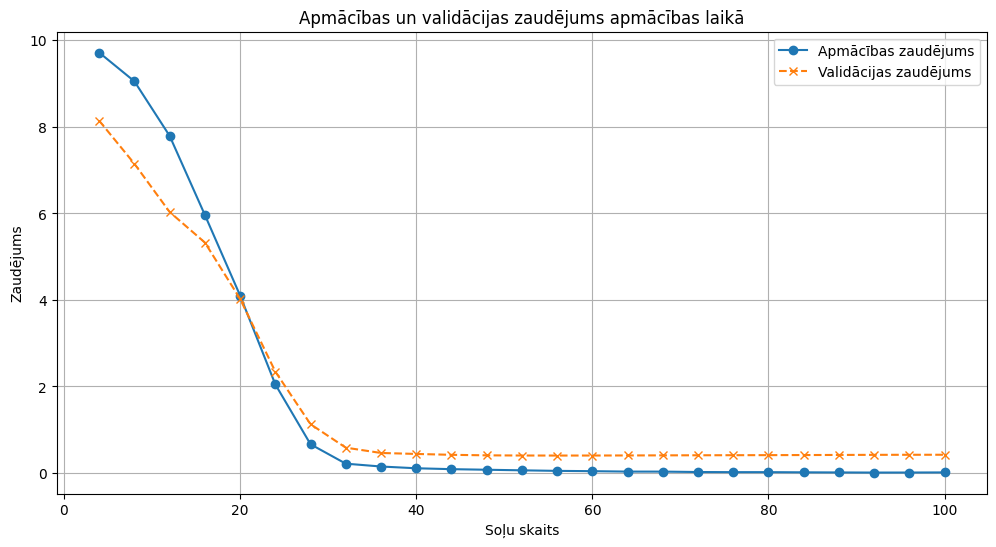

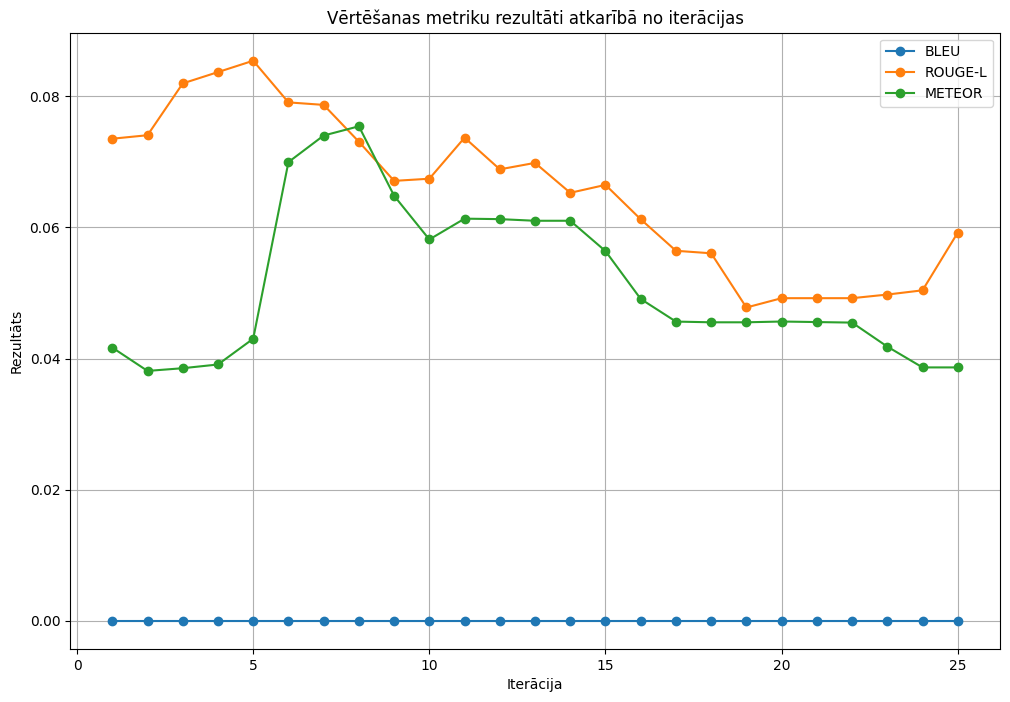

In [9]:
def plot_results(training_history):
    # Definējam sarakstus uzskaitei
    steps = []
    training_losses = []
    validation_losses = []

    # Ejam cauri katram ierakstam vēsturē
    for entry in training_history:
        if 'loss' in entry:  # Apmācības zaudējums
            steps.append(entry.get('step', len(steps) + 1))
            training_losses.append(entry['loss'])

        if 'eval_loss' in entry:  # Validācijas zaudējums
            validation_losses.append(entry['eval_loss'])

    # Izveidojam grafiku
    plt.figure(figsize=(12, 6))

    if training_losses:
        plt.plot(steps[:len(training_losses)], training_losses, label='Apmācības zaudējums', marker='o')

    if validation_losses:
        validation_steps = steps[:len(validation_losses)]
        plt.plot(validation_steps, validation_losses, label='Validācijas zaudējums', marker='x', linestyle='--')

    plt.xlabel('Soļu skaits')
    plt.ylabel('Zaudējums')
    plt.title('Apmācības un validācijas zaudējums apmācības laikā')
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_metrics_history(metrics_history):
    epochs = list(range(1, len(metrics_history)+1))
    plt.figure(figsize=(12, 8))

    # Sagatavojam datus parādīšanai grafikā
    bleu_scores = [x['bleu'] for x in metrics_history]
    rouge_scores = [x['rougeL'] for x in metrics_history]
    meteor_scores = [x['meteor'] for x in metrics_history]

    plt.plot(epochs, bleu_scores, label='BLEU', marker='o')
    plt.plot(epochs, rouge_scores, label='ROUGE-L', marker='o')
    plt.plot(epochs, meteor_scores, label='METEOR', marker='o')

    plt.xlabel('Iterācija')
    plt.ylabel('Rezultāts')
    plt.title('Vērtēšanas metriku rezultāti atkarībā no iterācijas')
    plt.legend()
    plt.grid(True)
    plt.show()

# Izpildām tikai, ja ir notikusi modeļa pielāgošana, citādi tas tiks darīts "Saglabātā modeļa izmantošana" sadaļā
if TRAIN:
    plot_results(trainer.state.log_history)
    print()
    plot_metrics_history(metrics_history)

# Čatbota interfeiss

In [10]:
def generate_text(model, tokenizer, input_text, max_length=150):
    # Tokenizējam ievadīto tekstu
    input_ids = tokenizer.encode(input_text, return_tensors='pt').to(model.device)

    # Modelis ģenerē tekstu
    output = model.generate(
        input_ids,
        max_length=max_length + len(input_ids[0]),
        num_return_sequences=1,
        no_repeat_ngram_size=2,
        temperature=0.9,
        top_k=50,
        top_p=0.95,
        pad_token_id=tokenizer.eos_token_id,
        do_sample=True
    )

    # Dekodējam tekstu un atgriežam to
    generated_text = tokenizer.decode(output[0], skip_special_tokens=True)
    return generated_text

def chat_with_model(model, tokenizer):
    print("Sāciet tērzēšanu ar modeli (ierakstiet 'q', lai izietu):")

    while True:
        input_text = input("You: ")

        if input_text.lower() == 'q':
            break

        response = generate_text(model, tokenizer, input_text)
        print("Bot:", response)

if CHAT:
    chat_with_model(model, tokenizer)

Sāciet tērzēšanu ar modeli (ierakstiet 'q', lai izietu):
You: Talk about your favorite food.
Bot: Talk about your favorite food. Discuss the benefits of reading.
You: Talk about your favorite food.
Bot: Talk about your favorite food. Describe a popular food destination.
You: Talk about your favorite food.
Bot: Talk about your favorite food.
You: Talk about your favorite food.
Bot: Talk about your favorite food.
You: Talk about your favorite food.
Bot: Talk about your favorite food.
You: Talk about your favorite food.
Bot: Talk about your favorite food. Describe a popular breakfast.
You: Talk about your favorite food.
Bot: Talk about your favorite food.
You: You can't talk about fruits.
Bot: You can't talk about fruits. Talk about your favorite food.
You: You can't talk about fruits.
Bot: You can't talk about fruits. Describe a healthy breakfast.
You: You can't talk about fruits.
Bot: You can't talk about fruits. Talk about healthy lifestyle choices."
You: You can't talk about fruits.
B

# Apmācīta modeļa saglabāšana

In [11]:
if TRAIN:
    model_weights = 'modelis.pth'
    torch.save(model.state_dict(), model_weights)

# Neapmācīta modeļa analīze



In [13]:
if FINE_TUNED:
    !wget model_link

    # Ielādējam saglabātos svarus
    model.load_state_dict(torch.load(model_weight_file))

    # Pārbaudām CUDA pieejamību un uzstādām modeli uz atbilstošās ierīces
    model.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))

    # Ieslēdzam validācijas režīmu
    trainer.evaluate(val_dataset)
    plot_metrics_history(metrics_history)